In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

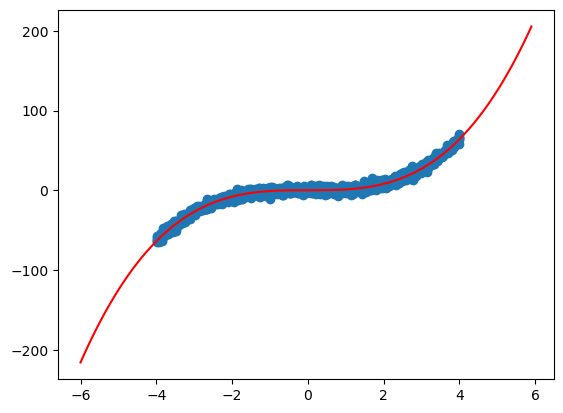

In [11]:
n = 1000
X = np.random.default_rng().uniform(-4, 4, size=n)

std = 3.0
noise = np.random.default_rng().normal(loc=0.0, scale=std, size=n)

y = X ** 3 + noise

plt.scatter(X, y)
plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')

In [12]:
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

import tensorflow as tf
from evml.keras.callbacks import get_callbacks, ReportEpoch
from evml.keras.models import EvidentialRegressorDNN

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

In [14]:
y_train.shape

(800, 1)

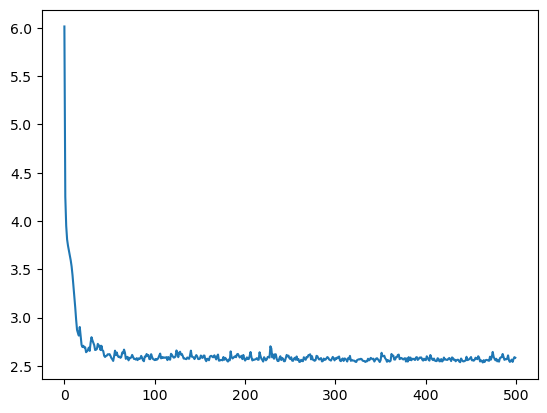

In [15]:
np.random.seed(986)
coupling = 2.0
mlp = EvidentialRegressorDNN(hidden_layers=3,
                            hidden_neurons=100,
                            activation='relu',
                            loss='evidentialReg',
                            coupling_coef=coupling,
                            evidential_coef=0.001,
                            epochs = 500,
                            batch_size = 128,
                            optimizer='adam',
                            lr=5e-3,
                            l2_weight=0.0,
                            l1_weight=0.0)
mlp.build_neural_network(1,1)
history = mlp.fit(X_train, y_train)
plt.plot(history.history['loss'])

7/7 [==============================] - 0s 895us/step


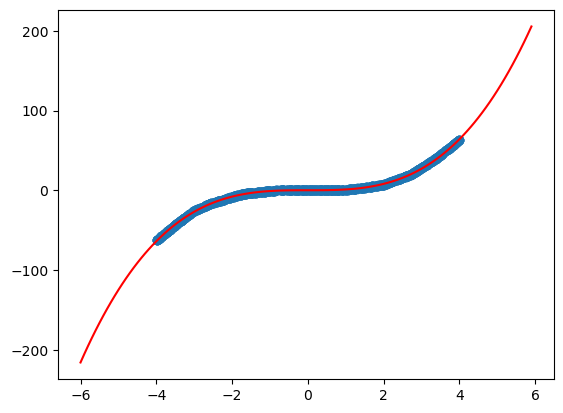

In [16]:
mu, v, alpha, beta = mlp.predict_dist_params(X_train)
plt.scatter(X_train, mu)

plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')

2/2 [==============================] - 0s 2ms/step


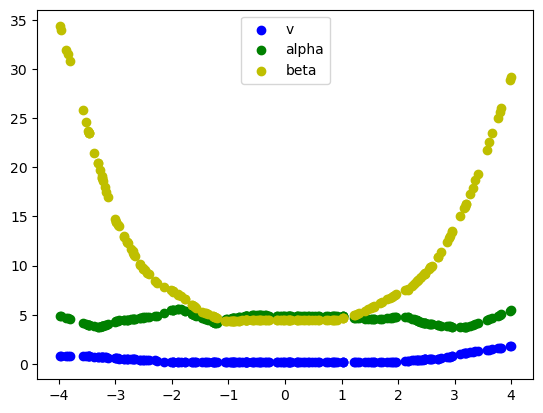

In [17]:
mu, v, alpha, beta = mlp.predict_dist_params(X_test)
plt.scatter(X_test, v, color='b').set_label("v")
plt.scatter(X_test, alpha, color='g').set_label("alpha")
plt.scatter(X_test, beta, color='y').set_label("beta")
plt.legend()


In [18]:
X_test = np.concatenate((X_test, np.arange(-6,-4,0.1), np.arange(4,6,0.1)))

mu, al, epis = mlp.predict(X_test, scaler=None, batch_size=None)

2/2 [==============================] - 0s 4ms/step


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

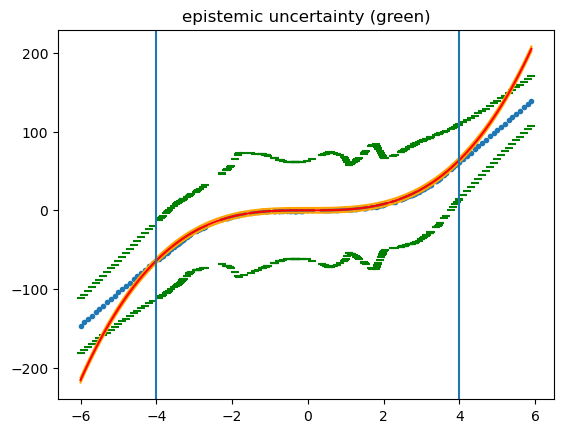

In [ ]:
al = np.sqrt(al)
epis = np.sqrt(epis)

ax = plt.gca()

ax.scatter(X_test, mu, marker='.')
ax.scatter(X_test, mu + epis,c = 'g', marker='_')
ax.scatter(X_test, mu - epis,c ='g', marker='_')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 + 3, color='orange')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 - 3, color='orange')


plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')
ax.axvline(4)
ax.axvline(-4)
_ = ax.set_title('epistemic uncertainty (green)')

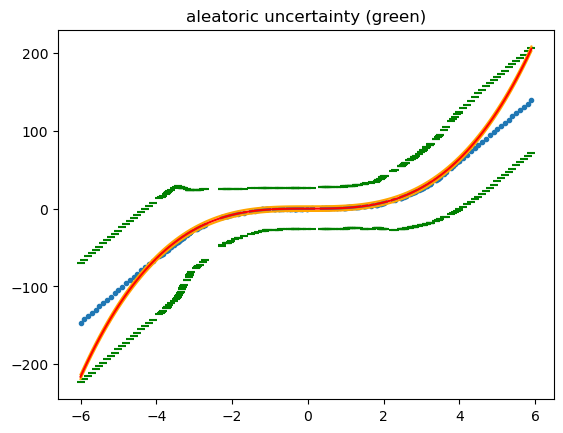

In [ ]:
ax = plt.gca()

ax.scatter(X_test, mu, marker='.')
ax.scatter(X_test, mu + al,c = 'g', marker='_')
ax.scatter(X_test, mu - al,c ='g', marker='_')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 + 3, color='orange')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 - 3, color='orange')


plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')
_ = ax.set_title('aleatoric uncertainty (green)')
